In [120]:
import numpy as np
from matplotlib import pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

In [121]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[]


In [122]:
N = 10**5

np.random.seed(42)

#Synthetic
theta0_G = np.random.normal(0.2,0.8,N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

#Natural
theta_unknown_G = np.random.normal(0,1, N)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G]) 

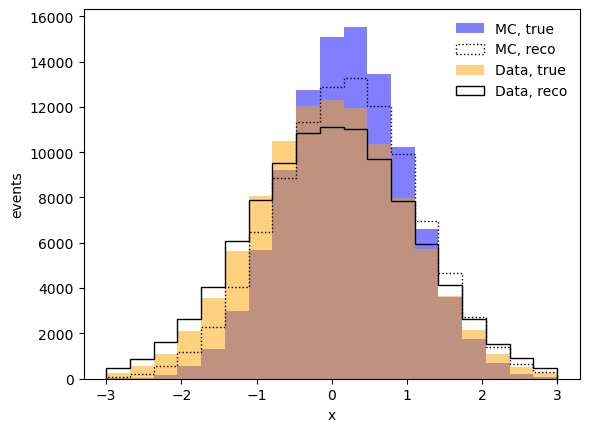

In [123]:
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S,bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S,bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

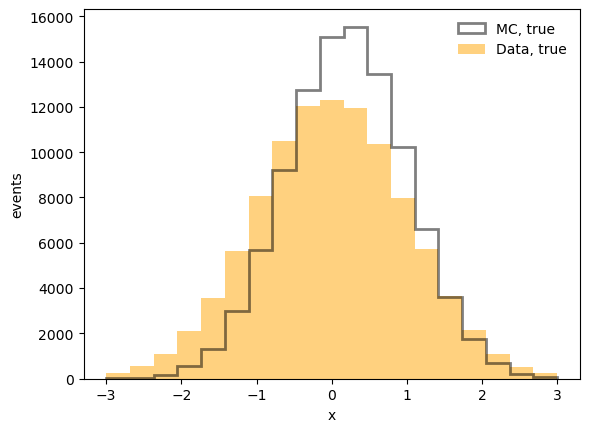

In [124]:
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),histtype="step",color='black',alpha=0.5,label="MC, true",lw=2)
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

In [125]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [126]:
myweights = of.omnifold(theta0,theta_unknown_S,3,model)

10/10 [==============================] - 0s 1ms/step


In [127]:
print(myweights.shape)

(3, 2, 100000)


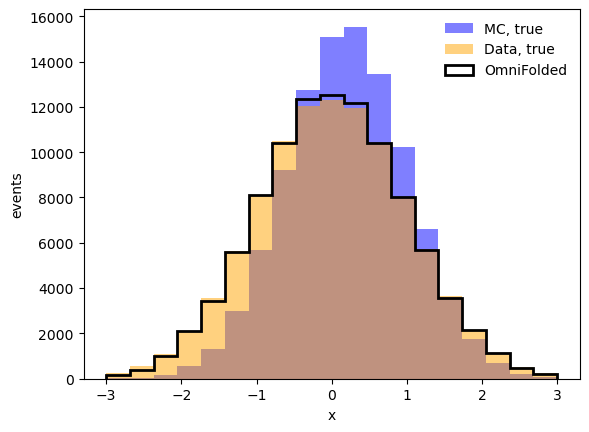

In [128]:
_, _, _ = plt.hist(
    theta0_G,
    bins=np.linspace(-3, 3, 20),
    color='blue',
    alpha=0.5,
    label="MC, true"
)
_, _, _ = plt.hist(
    theta_unknown_G,
    bins=np.linspace(-3, 3, 20),
    color='orange',
    alpha=0.5,
    label="Data, true"
)

# Select the detector-to-particle weights from the final iteration
weights_final = myweights[-1, 0, :]  # Final iteration, detector-to-particle weights

_, _, _ = plt.hist(
    theta0_G,
    weights=weights_final,
    bins=np.linspace(-3, 3, 20),
    color='black',
    histtype="step",
    label="OmniFolded",
    lw=2
)
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)
plt.show()


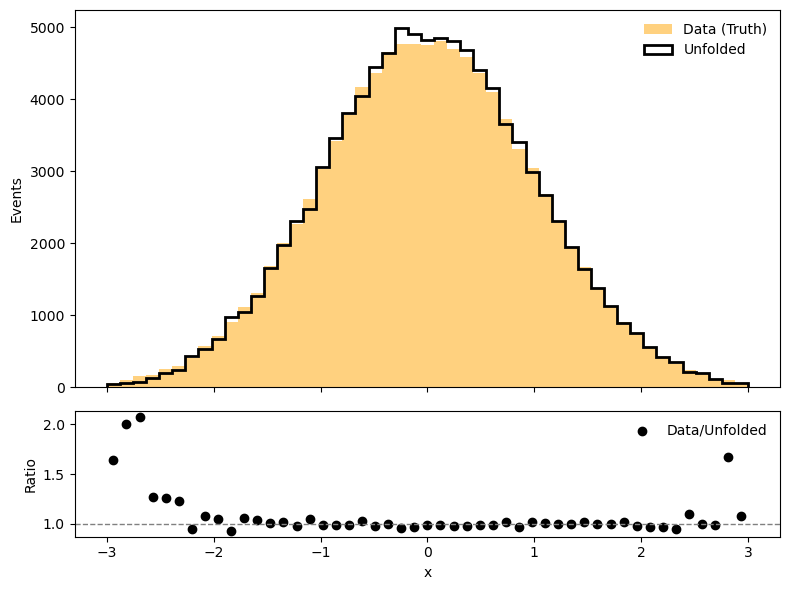

In [129]:
# Define bins
bins = np.linspace(-3, 3, 50)

# Create histograms
data_counts, bin_edges = np.histogram(theta_unknown_G, bins=bins)
unfolded_counts, _ = np.histogram(theta0_G, bins=bins, weights=myweights[-1, 0, :])

# Calculate the bin centers for plotting
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Calculate the ratio (avoid division by zero)
ratio = np.divide(
    data_counts, unfolded_counts, 
    out=np.zeros_like(data_counts, dtype=float), 
    where=(unfolded_counts != 0)
)

# Create the figure and subplots
fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

# Main plot: Truth and unfolded histograms
ax_main.hist(bin_centers, bins=bins, weights=data_counts, color='orange', alpha=0.5, label="Data (Truth)")
ax_main.hist(bin_centers, bins=bins, weights=unfolded_counts, histtype="step", color='black', label="Unfolded", lw=2)
ax_main.set_ylabel("Events")
ax_main.legend(frameon=False)

# Ratio plot
ax_ratio.scatter(bin_centers, ratio, color='black', label="Data/Unfolded")
ax_ratio.axhline(1, color='gray', linestyle='--', lw=1)  # Reference line at ratio = 1
ax_ratio.set_xlabel("x")
ax_ratio.set_ylabel("Ratio")
ax_ratio.legend(frameon=False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()